Using device: cuda
Epoch 1: Loss=191.3637, Recon=185.5242, KL=5.8395
Epoch 2: Loss=168.4115, Recon=162.9912, KL=5.4203
Epoch 3: Loss=163.7463, Recon=158.2058, KL=5.5406
Epoch 4: Loss=161.1101, Recon=155.5063, KL=5.6038
Epoch 5: Loss=159.3406, Recon=153.6565, KL=5.6840
Epoch 6: Loss=157.9629, Recon=152.2359, KL=5.7270
Epoch 7: Loss=156.8715, Recon=151.0691, KL=5.8024
Epoch 8: Loss=155.9890, Recon=150.1512, KL=5.8378
Epoch 9: Loss=155.2216, Recon=149.3451, KL=5.8765
Epoch 10: Loss=154.5172, Recon=148.5941, KL=5.9231

=== Test Metrics ===
Total loss per datapoint: 154.80132797851562
Recon loss per datapoint: 148.91776691894532
KL divergence per datapoint: 5.883560395812988


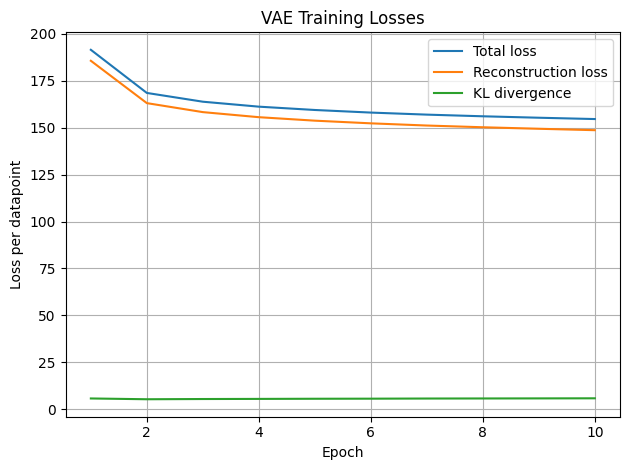

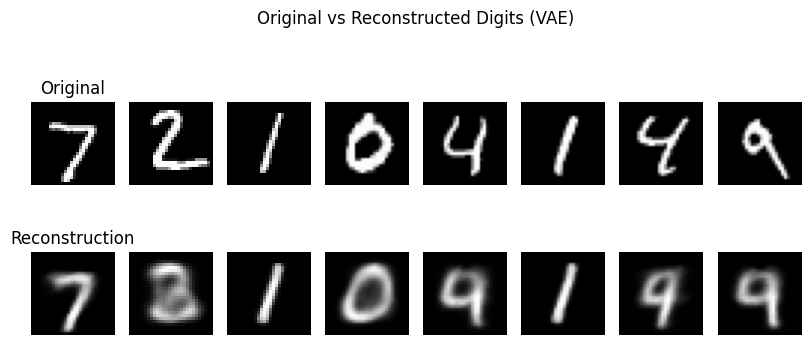

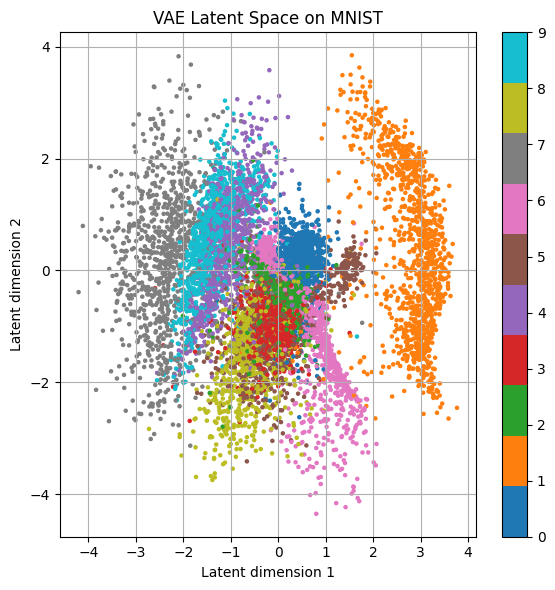

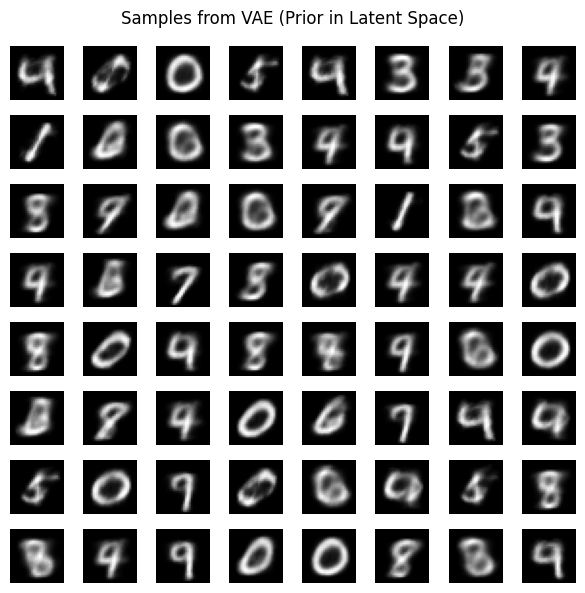

In [3]:
# Variational Autoencoder on MNIST (single cell)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------------------------------------------------
# 1. Device and random seed
# ---------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
if device.type == "cuda":
    torch.cuda.manual_seed_all(42)

print("Using device:", device)

# ---------------------------------------------------------------------
# 2. Data loading (MNIST)
# ---------------------------------------------------------------------
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(),  # [0,1]
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# ---------------------------------------------------------------------
# 3. VAE model definition
# ---------------------------------------------------------------------
class VAE(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dim=400, latent_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        logits = self.fc3(h)
        # We will use BCEWithLogitsLoss, so return raw logits
        return logits

    def forward(self, x):
        # x: (B, 1, 28, 28)
        x = x.view(x.size(0), -1)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        logits = self.decode(z)
        return logits, mu, logvar

# ---------------------------------------------------------------------
# 4. Loss function (negative ELBO)
# ---------------------------------------------------------------------
def vae_loss(logits, x, mu, logvar):
    # Flatten input
    x = x.view(x.size(0), -1)
    # Reconstruction loss: BCE with logits
    recon_loss = F.binary_cross_entropy_with_logits(logits, x, reduction='sum')
    # KL divergence between q(z|x) and N(0, I)
    # KL = -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Total negative ELBO
    return recon_loss + kl, recon_loss, kl

# ---------------------------------------------------------------------
# 5. Instantiate model and optimiser
# ---------------------------------------------------------------------
latent_dim = 2
model = VAE(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# ---------------------------------------------------------------------
# 6. Training loop
# ---------------------------------------------------------------------
num_epochs = 10
train_total_losses = []
train_recon_losses = []
train_kl_losses = []

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0.0
    total_recon = 0.0
    total_kl = 0.0
    num_samples = 0

    for x, _ in train_loader:
        x = x.to(device)
        optimizer.zero_grad()

        logits, mu, logvar = model(x)
        loss, recon_loss, kl_loss = vae_loss(logits, x, mu, logvar)
        loss.backward()
        optimizer.step()

        batch_size_curr = x.size(0)
        total_loss += loss.item()
        total_recon += recon_loss.item()
        total_kl += kl_loss.item()
        num_samples += batch_size_curr

    avg_total = total_loss / num_samples
    avg_recon = total_recon / num_samples
    avg_kl = total_kl / num_samples

    train_total_losses.append(avg_total)
    train_recon_losses.append(avg_recon)
    train_kl_losses.append(avg_kl)

    print(f"Epoch {epoch}: Loss={avg_total:.4f}, Recon={avg_recon:.4f}, KL={avg_kl:.4f}")

# ---------------------------------------------------------------------
# 7. Test evaluation
# ---------------------------------------------------------------------
model.eval()
test_total = 0.0
test_recon = 0.0
test_kl = 0.0
num_test_samples = 0

with torch.no_grad():
    for x, _ in test_loader:
        x = x.to(device)
        logits, mu, logvar = model(x)
        loss, recon_loss, kl_loss = vae_loss(logits, x, mu, logvar)

        batch_size_curr = x.size(0)
        test_total += loss.item()
        test_recon += recon_loss.item()
        test_kl += kl_loss.item()
        num_test_samples += batch_size_curr

test_total_avg = test_total / num_test_samples
test_recon_avg = test_recon / num_test_samples
test_kl_avg = test_kl / num_test_samples

print("\n=== Test Metrics ===")
print(f"Total loss per datapoint: {test_total_avg}")
print(f"Recon loss per datapoint: {test_recon_avg}")
print(f"KL divergence per datapoint: {test_kl_avg}")

# ---------------------------------------------------------------------
# 8. Plots: loss curves
# ---------------------------------------------------------------------
epochs = np.arange(1, num_epochs + 1)

plt.figure()
plt.plot(epochs, train_total_losses, label="Total loss")
plt.plot(epochs, train_recon_losses, label="Reconstruction loss")
plt.plot(epochs, train_kl_losses, label="KL divergence")
plt.xlabel("Epoch")
plt.ylabel("Loss per datapoint")
plt.title("VAE Training Losses")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 9. Visualise original vs reconstructed images
# ---------------------------------------------------------------------
model.eval()
with torch.no_grad():
    x, _ = next(iter(test_loader))
    x = x.to(device)
    logits, mu, logvar = model(x)
    recon = torch.sigmoid(logits)

# Take first 8 images
n = 8
orig = x[:n].cpu().view(n, 28, 28)
rec = recon[:n].cpu().view(n, 28, 28)

plt.figure(figsize=(8, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    ax.imshow(orig[i].detach().numpy(), cmap="gray")
    ax.axis("off")
    if i == 0:
        ax.set_title("Original")

    # Reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    ax.imshow(rec[i].detach().numpy(), cmap="gray")
    ax.axis("off")
    if i == 0:
        ax.set_title("Reconstruction")

plt.suptitle("Original vs Reconstructed Digits (VAE)")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 10. Latent space visualisation (for 2D latent_dim)
# ---------------------------------------------------------------------
if latent_dim == 2:
    all_mu = []
    all_labels = []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            x_flat = x.view(x.size(0), -1)
            mu, logvar = model.encode(x_flat)
            all_mu.append(mu.cpu())
            all_labels.append(y)

    all_mu = torch.cat(all_mu, dim=0).detach().numpy()
    all_labels = torch.cat(all_labels, dim=0).detach().numpy()

    plt.figure(figsize=(6, 6))
    scatter = plt.scatter(all_mu[:, 0], all_mu[:, 1], c=all_labels, s=5, cmap="tab10")
    plt.colorbar(scatter, ticks=range(10))
    plt.xlabel("Latent dimension 1")
    plt.ylabel("Latent dimension 2")
    plt.title("VAE Latent Space on MNIST")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------------------
# 11. Sampling from the prior
# ---------------------------------------------------------------------
model.eval()
with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    logits = model.decode(z)
    samples = torch.sigmoid(logits).cpu().view(-1, 28, 28)

plt.figure(figsize=(6, 6))
for i in range(64):
    ax = plt.subplot(8, 8, i + 1)
    ax.imshow(samples[i].detach().numpy(), cmap="gray")
    ax.axis("off")
plt.suptitle("Samples from VAE (Prior in Latent Space)")
plt.tight_layout()
plt.show()
